In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from pathlib import Path
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import torch.nn.init as init

In [25]:
# Define your dataset class
class NpyDataset(Dataset):
    def __init__(self, npy_files_folder):
        # Convert the string path to a Path object
        npy_files_folder_path = Path(npy_files_folder)
        # Load all .npy files in the folder
        self.data = [np.load(file) for file in npy_files_folder_path.glob("*.npy")]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32)

In [26]:
# Load data
data_folder = "map_arrays"
dataset = NpyDataset(data_folder)

In [27]:
data_size = len(dataset)
data_size ## should be 128

128

In [28]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split dataset into train, validation, and test sets
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

In [29]:
train_data[0].shape ## should be torch.Size([11, 16, 42])

torch.Size([11, 16, 42])

In [30]:
train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)
val_dataloader = DataLoader(val_data, batch_size=1, shuffle=False)

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [33]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim=512):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim

        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mean = nn.Linear(hidden_dim, latent_dim)  # Mean of the latent space
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)  # Log variance of the latent space

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
        
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def encode(self, x):
        x = F.relu(self.fc1(x))
        mean = self.fc2_mean(x)
        logvar = self.fc2_logvar(x)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
        z = F.relu(self.fc3(z))
        reconstruction = torch.sigmoid(self.fc4(z))
        return reconstruction

    def forward(self, x):
        # Flatten the input tensor
        x_flat = x.view(-1, self.input_dim)
        
        mean, logvar = self.encode(x_flat)
        z = self.reparameterize(mean, logvar)
        reconstruction_flat = self.decode(z)
        
        # Reshape the reconstructed flat tensor back to its original shape
        reconstruction = reconstruction_flat.view(-1, 11, 16, 42)
        
        return reconstruction, mean, logvar

In [34]:
def vae_loss_function(reconstruction, x, mu, logvar):
    # Reshape the target tensor to match the shape of the reconstruction
    x = x.view(-1, 11, 16, 42)
    
    # Compute reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(reconstruction, x, reduction='sum')

    # Compute KL divergence
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss
    total_loss = reconstruction_loss + kl_divergence
    return total_loss

In [35]:
# Reinitialize the model weights
def reset_model_weights(model):
    for param in model.parameters():
        if param.requires_grad:
            if len(param.shape) > 1:  # Check if the parameter is not a bias
                nn.init.xavier_uniform_(param)
            else:
                nn.init.constant_(param, 0)
    return model

Iter 1/13, LR: 1.0e-08, Train Loss: 5144.671875, Val Loss: 5142.77783203125
Iter 1/13, LR: 1.1e-08, Train Loss: 5146.37255859375, Val Loss: 5156.31982421875
Iter 1/13, LR: 1.2e-08, Train Loss: 5148.99072265625, Val Loss: 5149.0703125
Iter 1/13, LR: 1.3e-08, Train Loss: 5139.240234375, Val Loss: 5145.8173828125
Iter 1/13, LR: 1.5e-08, Train Loss: 5139.947265625, Val Loss: 5142.0546875
Iter 1/13, LR: 1.6e-08, Train Loss: 5137.4609375, Val Loss: 5139.01953125
Iter 1/13, LR: 1.8e-08, Train Loss: 5137.66650390625, Val Loss: 5141.0400390625
Iter 1/13, LR: 1.9e-08, Train Loss: 5135.857421875, Val Loss: 5137.76123046875
Iter 1/13, LR: 2.1e-08, Train Loss: 5141.484375, Val Loss: 5128.69580078125
Iter 1/13, LR: 2.4e-08, Train Loss: 5141.142578125, Val Loss: 5139.88525390625
Iter 1/13, LR: 2.6e-08, Train Loss: 5132.34033203125, Val Loss: 5141.9912109375
Iter 1/13, LR: 2.9e-08, Train Loss: 5149.1650390625, Val Loss: 5137.82568359375
Iter 2/13, LR: 3.1e-08, Train Loss: 5136.41650390625, Val Loss: 5

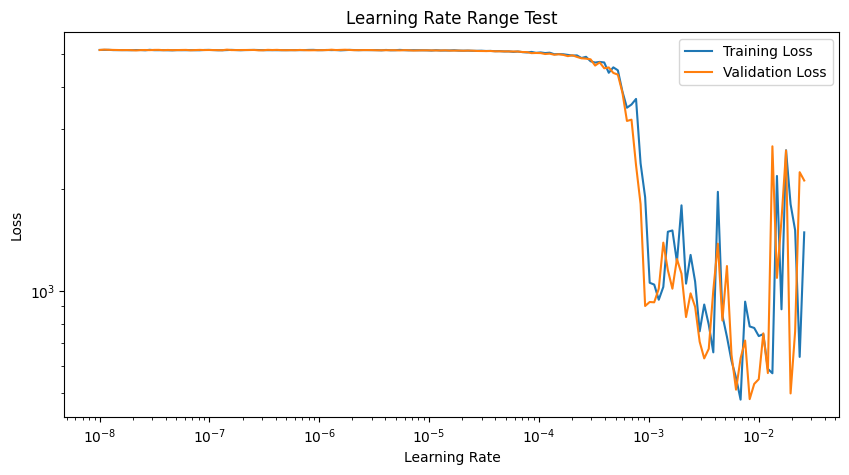

Iter 1/13, LR: 1.0e-08, Train Loss: 5141.7392578125, Val Loss: 5136.68359375
Iter 1/13, LR: 1.1e-08, Train Loss: 5132.171875, Val Loss: 5141.3603515625
Iter 1/13, LR: 1.2e-08, Train Loss: 5134.97802734375, Val Loss: 5132.90185546875
Iter 1/13, LR: 1.3e-08, Train Loss: 5138.1083984375, Val Loss: 5134.81884765625
Iter 1/13, LR: 1.5e-08, Train Loss: 5135.2421875, Val Loss: 5131.763671875
Iter 1/13, LR: 1.6e-08, Train Loss: 5135.89892578125, Val Loss: 5137.615234375
Iter 1/13, LR: 1.8e-08, Train Loss: 5131.0673828125, Val Loss: 5135.666015625
Iter 1/13, LR: 1.9e-08, Train Loss: 5140.85546875, Val Loss: 5142.02294921875
Iter 1/13, LR: 2.1e-08, Train Loss: 5136.45166015625, Val Loss: 5136.6044921875
Iter 1/13, LR: 2.4e-08, Train Loss: 5136.78515625, Val Loss: 5132.486328125
Iter 1/13, LR: 2.6e-08, Train Loss: 5137.2919921875, Val Loss: 5144.96044921875
Iter 1/13, LR: 2.9e-08, Train Loss: 5133.9326171875, Val Loss: 5139.31591796875
Iter 2/13, LR: 3.1e-08, Train Loss: 5129.61181640625, Val Los

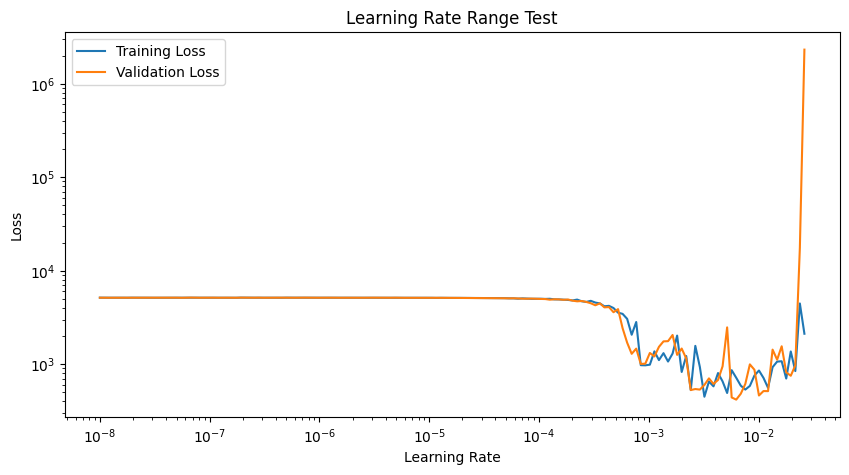

Iter 1/13, LR: 1.0e-08, Train Loss: 5137.4423828125, Val Loss: 5147.42529296875
Iter 1/13, LR: 1.1e-08, Train Loss: 5130.53125, Val Loss: 5141.13037109375
Iter 1/13, LR: 1.2e-08, Train Loss: 5144.4248046875, Val Loss: 5132.501953125
Iter 1/13, LR: 1.3e-08, Train Loss: 5136.11669921875, Val Loss: 5134.080078125
Iter 1/13, LR: 1.5e-08, Train Loss: 5132.78759765625, Val Loss: 5137.5791015625
Iter 1/13, LR: 1.6e-08, Train Loss: 5132.162109375, Val Loss: 5141.6259765625
Iter 1/13, LR: 1.8e-08, Train Loss: 5135.13134765625, Val Loss: 5132.05224609375
Iter 1/13, LR: 1.9e-08, Train Loss: 5134.57861328125, Val Loss: 5142.98974609375
Iter 1/13, LR: 2.1e-08, Train Loss: 5134.15869140625, Val Loss: 5134.99560546875
Iter 1/13, LR: 2.4e-08, Train Loss: 5133.42236328125, Val Loss: 5145.42724609375
Iter 1/13, LR: 2.6e-08, Train Loss: 5151.626953125, Val Loss: 5149.29150390625
Iter 1/13, LR: 2.9e-08, Train Loss: 5137.5751953125, Val Loss: 5142.35986328125
Iter 2/13, LR: 3.1e-08, Train Loss: 5138.472656

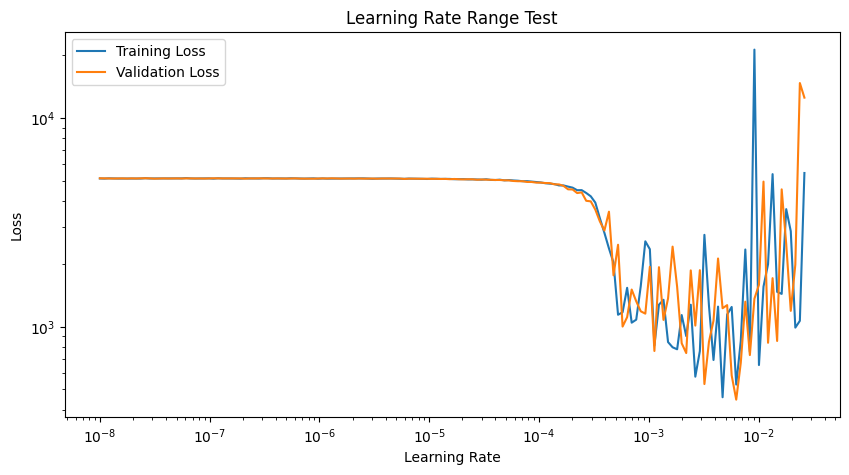

Iter 1/13, LR: 1.0e-08, Train Loss: 5137.6728515625, Val Loss: 5136.34521484375
Iter 1/13, LR: 1.1e-08, Train Loss: 5133.80712890625, Val Loss: 5147.537109375
Iter 1/13, LR: 1.2e-08, Train Loss: 5134.45947265625, Val Loss: 5135.36669921875
Iter 1/13, LR: 1.3e-08, Train Loss: 5146.96875, Val Loss: 5135.6171875
Iter 1/13, LR: 1.5e-08, Train Loss: 5136.6943359375, Val Loss: 5139.06884765625
Iter 1/13, LR: 1.6e-08, Train Loss: 5141.45068359375, Val Loss: 5156.3955078125
Iter 1/13, LR: 1.8e-08, Train Loss: 5134.8681640625, Val Loss: 5130.9072265625
Iter 1/13, LR: 1.9e-08, Train Loss: 5137.6552734375, Val Loss: 5142.53369140625
Iter 1/13, LR: 2.1e-08, Train Loss: 5131.7783203125, Val Loss: 5140.6923828125
Iter 1/13, LR: 2.4e-08, Train Loss: 5139.42529296875, Val Loss: 5143.7451171875
Iter 1/13, LR: 2.6e-08, Train Loss: 5137.24560546875, Val Loss: 5130.9169921875
Iter 1/13, LR: 2.9e-08, Train Loss: 5138.2353515625, Val Loss: 5135.17138671875
Iter 2/13, LR: 3.1e-08, Train Loss: 5138.5600585937

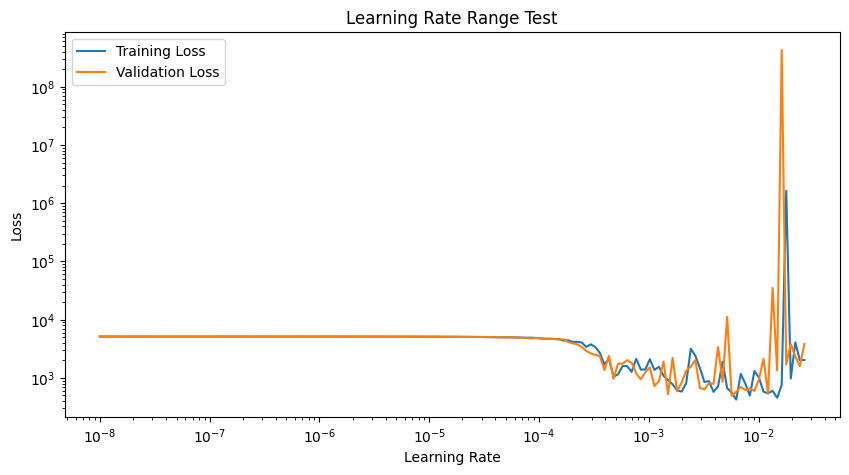

In [36]:
hidden_layer_sizes = [128, 256, 512, 1024]
best_hidden_dim = None

for hidden_dim in hidden_layer_sizes:

    # Instantiate the VAE model
    input_dim = 16 * 11 * 42
    latent_dim = 64  # Latent dimension
    model = VAE(input_dim, latent_dim, hidden_dim=hidden_dim).to(device)
    model = reset_model_weights(model)

    # Initialize optimizer with a very small learning rate
    initial_lr = 1e-8
    optimizer = optim.Adam(model.parameters(), lr=initial_lr)

    # Initialize lists to store learning rates, training losses, and validation losses
    lrs = []
    train_losses = []
    val_losses = []

    # Initialize variables to store the best loss and corresponding learning rate
    min_val_loss = float('inf')
    best_lr = initial_lr

    # Define the learning rate scheduler to exponentially increase the learning rate
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1.1)

    # Number of iterations for the LR range test
    num_iters = 13  # or a reasonable number of iterations

    model.train()
    for iter in range(num_iters):
        for train_batch, val_batch in zip(train_dataloader, val_dataloader):
            # Move batches to GPU
            train_batch = train_batch.to(device)
            val_batch = val_batch.to(device)
            
            optimizer.zero_grad()
            
            # Training phase
            train_outputs, train_mu, train_logvar = model(train_batch)
            train_loss = vae_loss_function(train_outputs, train_batch, train_mu, train_logvar)
            train_loss.backward()
            optimizer.step()
            
            # Validation phase
            model.eval()  # switch to evaluation mode
            with torch.no_grad():
                val_outputs, val_mu, val_logvar = model(val_batch)
                val_loss = vae_loss_function(val_outputs, val_batch, val_mu, val_logvar)
            
            # Record the current learning rate and losses
            current_lr = optimizer.param_groups[0]['lr']
            lrs.append(current_lr)
            train_losses.append(train_loss.item())
            val_losses.append(val_loss.item())
            
            # Check for the minimum validation loss and corresponding learning rate
            if val_loss < min_val_loss:
                min_val_loss = val_loss
                best_lr = current_lr
            
            # Step the learning rate scheduler
            scheduler.step()
            
            # Print progress
            print(f"Iter {iter+1}/{num_iters}, LR: {current_lr:.1e}, Train Loss: {train_loss.item()}, Val Loss: {val_loss.item()}")

    print(f"Lowest validation loss of {min_val_loss:.4f} obtained at learning rate {best_lr:.1e}")
    # Plot the learning rate range test
    plt.figure(figsize=(10, 5))
    plt.plot(lrs, train_losses, label='Training Loss')
    plt.plot(lrs, val_losses, label='Validation Loss')
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.yscale('log')
    plt.ylabel('Loss')
    plt.title('Learning Rate Range Test')
    plt.legend()
    plt.show()


In [37]:
# Reset the model weights
model = reset_model_weights(model)
model = VAE(input_dim, latent_dim, hidden_dim=128).to(device)

In [38]:
# Initialize lists to store losses
train_losses = []
test_losses = []

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=best_lr)
# optimizer = optim.Adam(model.parameters(), lr=0.001)


best_loss = float('inf')  # Initialize best loss to positive infinity
best_epoch = 0  # Initialize the epoch at which the best loss occurred

num_epochs = 300
patience = 50

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch in train_dataloader:
        # Move batch to GPU
        batch = batch.to(device)
        
        optimizer.zero_grad()
        outputs, mu, logvar = model(batch)
        loss = vae_loss_function(outputs, batch, mu, logvar)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    average_train_loss = train_loss / len(train_dataloader)
    train_losses.append(average_train_loss)

    # Evaluate Model
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch in test_dataloader:
            batch = batch.to(device)
            outputs, mu, logvar = model(batch)
            test_loss += vae_loss_function(outputs, batch, mu, logvar).item()

    average_test_loss = test_loss / len(test_dataloader)
    test_losses.append(average_test_loss)

    print(f"Epoch {epoch+1}, Average Train Loss: {average_train_loss}, Average Test Loss: {average_test_loss}")

    # Check if the current test loss is the best so far
    if average_test_loss < best_loss:
        best_loss = average_test_loss
        best_epoch = epoch
        # Save the best model
        torch.save(model.state_dict(), 'best_vae_model.pth')

    # Check for early stopping criterion
    if epoch - best_epoch >= patience:
        print(f"No improvement in test loss for {patience} epochs. Early stopping.")
        break


Epoch 1, Average Train Loss: 704.4740629009171, Average Test Loss: 382.53644888741627
Epoch 2, Average Train Loss: 365.83795734480316, Average Test Loss: 381.2109135219029
Epoch 3, Average Train Loss: 332.4700891831342, Average Test Loss: 328.6440734863281
Epoch 4, Average Train Loss: 318.5188797595454, Average Test Loss: 320.67576599121094
Epoch 5, Average Train Loss: 314.43093228807635, Average Test Loss: 356.45790209089006
Epoch 6, Average Train Loss: 347.4033316817938, Average Test Loss: 338.9220711844308
Epoch 7, Average Train Loss: 317.9185677322687, Average Test Loss: 398.856564113072
Epoch 8, Average Train Loss: 308.68948080025467, Average Test Loss: 362.10909598214283
Epoch 9, Average Train Loss: 305.58663611318553, Average Test Loss: 394.10178920200894
Epoch 10, Average Train Loss: 315.55668355904373, Average Test Loss: 396.40614536830356
Epoch 11, Average Train Loss: 306.731175142176, Average Test Loss: 370.817374093192
Epoch 12, Average Train Loss: 312.5590883142808, Averag

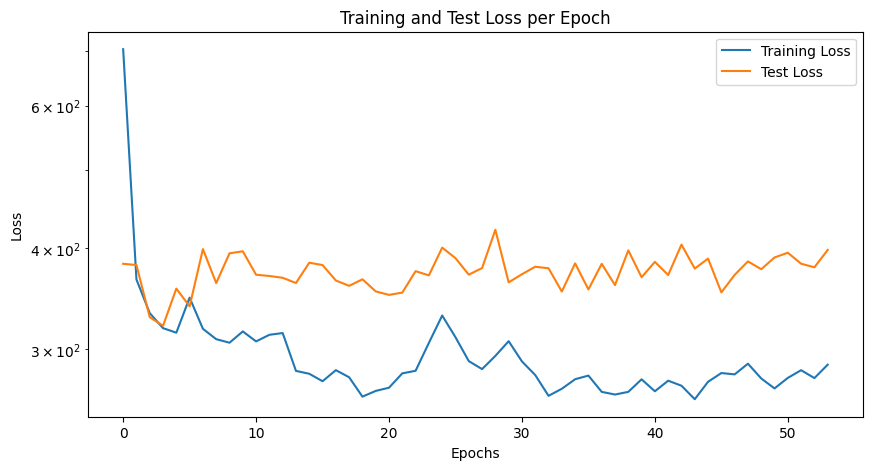

In [39]:
# Plotting the training and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss per Epoch')
plt.show()

In [40]:
tile_set_path = 'gray_tile'
tile_size = 16
tile_set = []
for filename in os.listdir(tile_set_path):
    tile = np.load(os.path.join(tile_set_path, filename))
    tile_set.append(tile)

In [41]:
def convert_embedding_to_image(embedding, tile_set, tile_size):
    num_tiles_h, num_tiles_w, _ = embedding.shape
    # Initialize the image with the appropriate dimensions
    reconstructed_image = np.zeros((num_tiles_h * tile_size, num_tiles_w * tile_size), dtype=tile_set[0].dtype)
    
    # Loop through each position in the embedding array
    for i in range(num_tiles_h):
        for j in range(num_tiles_w):
            # Find the index of the tile (one-hot encoding)
            tile_index = np.argmax(embedding[i, j])
            # Retrieve the tile from the tile set
            tile = tile_set[tile_index]
            # Place the tile in the correct position in the reconstructed image
            reconstructed_image[i*tile_size:(i+1)*tile_size, j*tile_size:(j+1)*tile_size] = tile

    return reconstructed_image

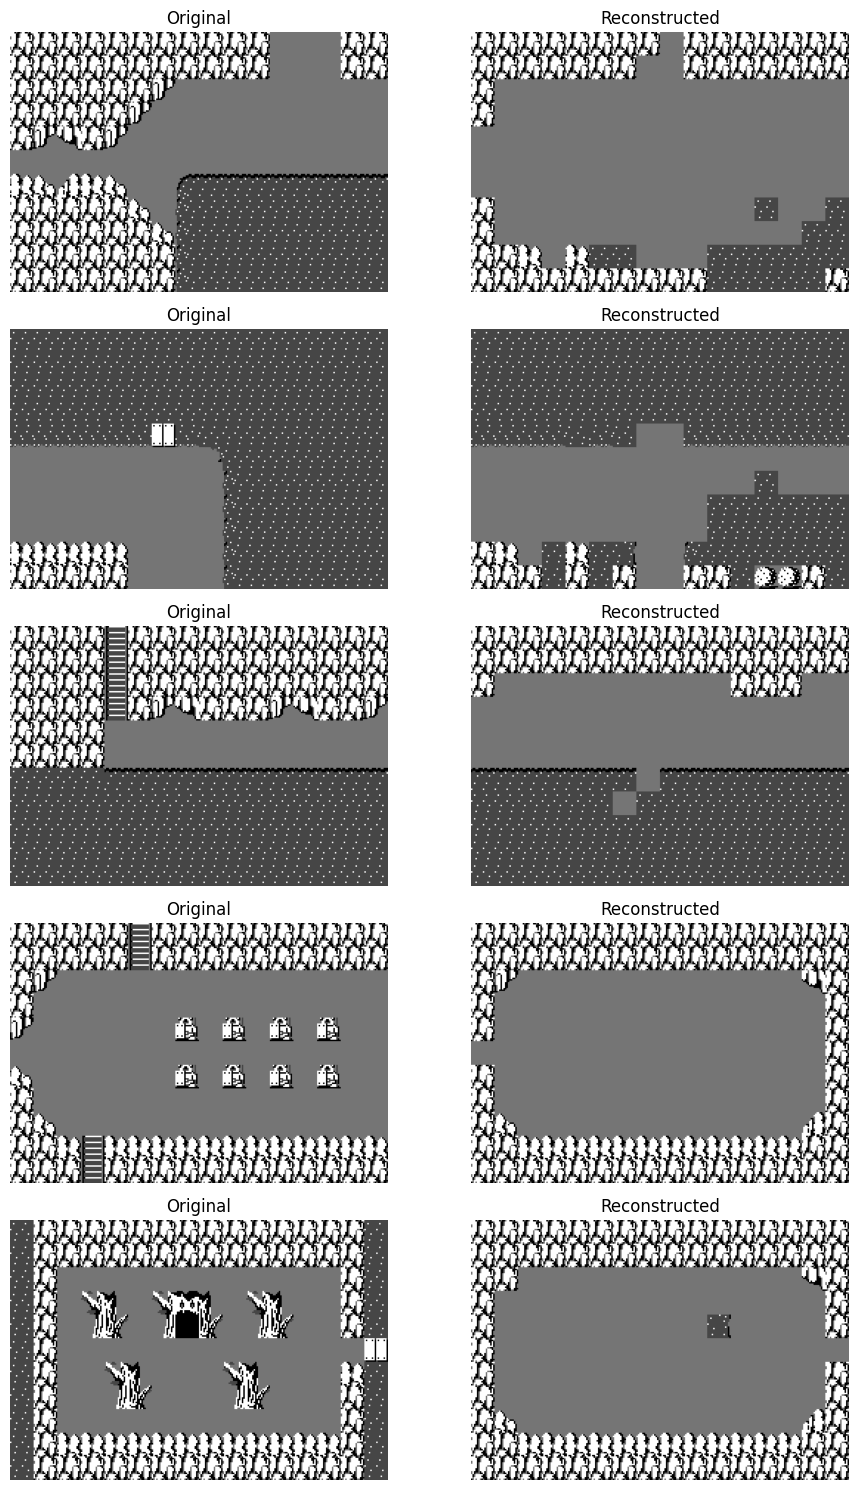

In [42]:
# Define a function to plot original and reconstructed images
def plot_images(original, reconstructed):
    num_images = min(original.size(0), 5)  # Plot up to 5 images
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 3*num_images))
    
    for i in range(num_images):
        # Plot original image
        img1 = convert_embedding_to_image(original[i].numpy(), tile_set, tile_size)
        axes[i, 0].imshow(img1.squeeze(), cmap='gray')
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')
        
        img2 = convert_embedding_to_image(reconstructed[i].numpy(), tile_set, tile_size)
        axes[i, 1].imshow(img2.squeeze(), cmap='gray')
        axes[i, 1].set_title('Reconstructed')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Load the best VAE model
best_vae_model = VAE(input_dim, latent_dim, hidden_dim=128).to(device)
best_vae_model.load_state_dict(torch.load('best_vae_model.pth'))

# Pass some test images through the VAE model to get reconstructed images
original_images = []
reconstructed_images = []

# Set the best VAE model to evaluation mode
best_vae_model.eval()

# Pass test batches through the best VAE model
with torch.no_grad():
    for batch in test_dataloader:
        # Move batch to GPU and convert to torch.float32
        batch = batch.to(torch.float32).to(device)
        
        # Forward pass using the best VAE model
        outputs, _, _ = best_vae_model(batch)
        
        # Append original and reconstructed images to lists
        original_images.append(batch.cpu())  # Move back to CPU for visualization
        reconstructed_images.append(outputs.cpu())  # Move back to CPU for visualization

# Concatenate lists of tensors into single tensors
original_images = torch.cat(original_images, dim=0)
reconstructed_images = torch.cat(reconstructed_images, dim=0)

# Plot the original and reconstructed images
plot_images(original_images, reconstructed_images)


In [43]:
best_vae_model = VAE(input_dim, latent_dim).to(device)
best_vae_model.load_state_dict(torch.load('best_vae_model.pth'))

# Set the VAE model to evaluation mode
best_vae_model.eval()

# Number of samples to generate
num_samples = 127

# Generate random samples from a standard normal distribution
z_samples = torch.randn(num_samples, latent_dim).to(device)

# Decode the samples
with torch.no_grad():
    generated_samples = model.decode(z_samples)

# Convert the generated samples back to numpy arrays
generated_samples = generated_samples.cpu().numpy()
generated_samples_reshaped = generated_samples.reshape(num_samples, 11, 16, 42)

output_dir = "generated_sample"
os.makedirs(output_dir, exist_ok=True)

for idx, sample in enumerate(generated_samples_reshaped):
    plt.figure(figsize=(3, 3))
    image = convert_embedding_to_image(sample, tile_set, tile_size)
    npy_path = os.path.join(output_dir, f'sample_{idx}.npy')
    np.save(npy_path, sample)
    if idx < 10:
        plt.imshow(image.squeeze(), cmap='gray')
        plt.axis('off')
        plt.show()

RuntimeError: Error(s) in loading state_dict for VAE:
	size mismatch for fc1.weight: copying a param with shape torch.Size([128, 7392]) from checkpoint, the shape in current model is torch.Size([512, 7392]).
	size mismatch for fc1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for fc2_mean.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([64, 512]).
	size mismatch for fc2_logvar.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([64, 512]).
	size mismatch for fc3.weight: copying a param with shape torch.Size([128, 64]) from checkpoint, the shape in current model is torch.Size([512, 64]).
	size mismatch for fc3.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for fc4.weight: copying a param with shape torch.Size([7392, 128]) from checkpoint, the shape in current model is torch.Size([7392, 512]).